# imports

In [1]:
import torch
import espaloma as esp

Using backend: pytorch


# integrator
We use a vanilla Euler method as our integrator.

In [2]:
def euler_method(qs, ps, q_grad, lr=1e-3):
    """ Euler method integration.
    
    Parameters
    ----------
    qs : `List` of `Tensor`
        The trajectories of position variables.
        
    ps : `List` of `Tensor`
        The trajectories of momentum variables.
        
    q_grad : `Tensor`
        Gradients (of energies) w.r.t. position variables at last step.
        
    Returns
    -------
    qs
    ps

    
    """
    q = qs[-1]
    p = ps[-1]

    if q_grad is None:
        q_grad = torch.zeros_like(q)

    p = p.clone().add(lr * q_grad)
    q = q.clone().add(lr * p)
   
    ps.append(p)
    qs.append(q)
    
    return qs, ps

# architecture

In [3]:
class NodeRNN(torch.nn.Module):
    """ HyperNode-level RNN to out put lambdas schedule.
    
    Parameters
    ----------
    input_size : `int`
        Input dimension.
        
    units : `int`
        Hidden dimension.
        
    Methods
    -------
    apply_nodes_fn :
        Function that is applied to all hypernodes
        and returns latent representation.
        
    forward :
        Forward pass.
        
    
    Attributes
    ----------
    rnn2 : `torch.nn.GRU`
        Bond-level RNN.
    
    rnn3 : `torch.nn.GRU`
        Angle-level RNN.
    
    d : `torch.nn.Linear`
        Final layer to output lambda scedules.
        
    
    """
    def __init__(self, input_size=32, units=128):
        super(NodeRNN, self).__init__()
        self.rnn2 = torch.nn.GRU(
            input_size=input_size+3,
            hidden_size=units,
            batch_first=True,
            bidirectional=True, # just to be more expressive
        )
        
        self.rnn3 = torch.nn.GRU(
            input_size=input_size+3,
            hidden_size=units,
            batch_first=True,
            bidirectional=True,
        )
        
        self.windows=48
        self.d = torch.nn.Linear(
            2 * units,
            1
        ) # we need to summarize the protocols to one-dimension

    def apply_nodes_fn(self, x, rnn):
        """ Applied to all hypernodes and returns latent representation."""
        # (number_of_hypernodes, number_of_windows, units)
        h_gn = x[:, None, :].repeat(1, self.windows, 1)
        
        # (number_of_hypernodes, number_of_windows,)
        h_total_number = torch.tensor([self.windows])[:, None].repeat(
            x.shape[0], self.windows).to(dtype=torch.float32)
        
        # (number_of_hypernodes, number_of_windows,)
        h_index = torch.arange(0, self.windows)[None, :].repeat(
            x.shape[0], 1).to(dtype=torch.float32)
        
        # (number_of_hypernodes, number_of_windows,)
        h_pct = h_index / h_total_number
        
        # (number_of_hypernodes, 3)
        h_indicator = torch.stack(
            [
                h_total_number,
                h_index,
                h_pct
            ],
            dim=2,
        )
        
        # (number_of_hypernodes, number_of_windows, 1)
        h = rnn(torch.cat([h_gn, h_indicator], dim=-1))[0]

        return self.d(h).squeeze(-1) # erase dimension (1)

    def forward(self, g):
        """ Forward pass. """
        # apply to both bond and angle.
        
        g.apply_nodes(
            lambda node: {'lambs_': self.apply_nodes_fn(node.data['h'], self.rnn2)},
            ntype='n2'
        )
        
        g.apply_nodes(
            lambda node: {'lambs_': self.apply_nodes_fn(node.data['h'], self.rnn3)},
            ntype='n3'
        )
        
        return g

In [4]:
class LambdaConstraint(torch.nn.Module):
    """ Constraint lambda schedules such that:
        * It is monotonically increasing.
        * It starts at zero and ends at one.
    
    """
    def __init__(self):
        super(LambdaConstraint, self).__init__()
        
    def forward(self, g):
        g.apply_nodes(
            lambda node: {'lambs': node.data['lambs_'].softmax(dim=-1).cumsum(dim=-1)},
            ntype='n2'
        )
        
        g.apply_nodes(
            lambda node: {'lambs': node.data['lambs_'].softmax(dim=-1).cumsum(dim=-1)},
            ntype='n3'
        )
        
        return g

In [5]:
g = esp.Graph('CC')
esp.graphs.LegacyForceField('smirnoff99Frosst').parametrize(g)


/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/dgl/base.py:25: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  warnings.warn(msg, warn_type)


In [6]:

layer = esp.nn.dgl_legacy.gn()

representation = esp.nn.Sequential(
    layer,
    [32, 'tanh', 32, 'tanh', 32, 'tanh'],
)

readout = esp.nn.readout.janossy.JanossyPooling(
    in_features=32,
    config=[32, 'tanh', 32],
    out_features={
        1: {'log_sigma': 1},
        2: {'h': 32},
        3: {'h': 32},
    }
)

node_rnn = NodeRNN()

lambda_constraint = LambdaConstraint()

net = torch.nn.Sequential(
    representation,
    readout,
    node_rnn,
    lambda_constraint,
)

In [7]:
def f(x, idx, x_init_distribution):
    """ Energy function. """
    # the first step, return the negative log prob as energy
    if idx == 0: 
        return -x_init_distribution.log_prob(x).sum(
            dim=(0, 2), # sum across nodes and space dimension
        )
    
    # the last step, return the target energy
    if idx == 49:
        # assign variable to xyz
        g.nodes['n1'].data['xyz'] = x
        
        # calculate geometries
        esp.mm.geometry.geometry_in_graph(g.heterograph)
        
        # calculate energies
        esp.mm.energy.energy_in_graph(g.heterograph, suffix='_ref')
        
        # only return bond and angle energy
        # (number_of_samples, )
        return 1e-3 * (g.nodes['n2'].data['u_ref'].sum(dim=0) + g.nodes['n3'].data['u_ref'].sum(dim=0))

    
    # same logic here,
    # only with biased potentials
    g.nodes['n1'].data['xyz'] = x
    esp.mm.geometry.geometry_in_graph(g.heterograph)
    esp.mm.energy.energy_in_graph(g.heterograph, suffix='_ref')

    g.heterograph.apply_nodes(
        lambda node: {'u': node.data['u_ref'] * node.data['lambs'][:, idx-1][:, None]},
        ntype='n2'
    )

    g.heterograph.apply_nodes(
        lambda node: {'u': node.data['u_ref'] * node.data['lambs'][:, idx-1][:, None]},
        ntype='n3'
    )

    return 1e-3 * (g.nodes['n2'].data['u'].sum(dim=0) + g.nodes['n3'].data['u'].sum(dim=0))



In [8]:

def loss():
    """ The loss function for the neural network parameters. """
    # parametrize the graph in-place
    net(g.heterograph)
    
    # the scale of the initial distribution is parametrized neurally
    scale = g.nodes['n1'].data['log_sigma'].exp()[:, None, :].repeat(1, 128, 3)
    
    # construct the initial distribution
    x_init_distribution = torch.distributions.normal.Normal(
        loc=torch.zeros(
            g.heterograph.number_of_nodes('n1'),
            128,
            3
        ),
        scale=scale,
    )
    
    # sample one for initial conformation
    x = x_init_distribution.sample()
    x.requires_grad = True

    # initialize the momentum
    q = torch.zeros_like(x)

    # here we record the entire trajectory since the computation graph
    # is always needed for autograd
    xs = [x]
    qs = [q]
    
    # initialize work
    # this broadcasts to (batch_size, )
    works = 0.0
    
    # loop through lambda schedules
    for idx in range(1, 50):
        x = xs[-1]
        q = qs[-1]

        # calculate old and new energy
        energy_old = f(x, idx-1, x_init_distribution=x_init_distribution)
        energy_new = f(x, idx, x_init_distribution=x_init_distribution)

        # calculate gradient 
        x_grad = torch.autograd.grad(
            energy_new.sum(),
            [x],
            create_graph=True,
        )[0]

        # integrate
        xs, qs = euler_method(xs, qs, x_grad)
        
        # calculate works
        works += energy_new - energy_old
        
    return works.std()



In [9]:
optimizer = torch.optim.Adam(net.parameters(), 1e-3)
losses = []
for _ in range(30):
    optimizer.zero_grad()
    def l():
        _loss = loss()
        _loss.backward(create_graph=True, retain_graph=True)
        print(_loss)
        losses.append(_loss.detach().numpy())
        return _loss
    optimizer.step(l)



/Users/wangy1/anaconda3/envs/pinot/lib/python3.7/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor(3171.0183, grad_fn=<StdBackward0>)
tensor(2880.8140, grad_fn=<StdBackward0>)
tensor(2234.9519, grad_fn=<StdBackward0>)
tensor(2618.9341, grad_fn=<StdBackward0>)
tensor(2217.8259, grad_fn=<StdBackward0>)
tensor(1977.9556, grad_fn=<StdBackward0>)
tensor(1411.0784, grad_fn=<StdBackward0>)
tensor(1086.5059, grad_fn=<StdBackward0>)
tensor(912.4058, grad_fn=<StdBackward0>)
tensor(747.5528, grad_fn=<StdBackward0>)
tensor(676.6880, grad_fn=<StdBackward0>)
tensor(549.1262, grad_fn=<StdBackward0>)
tensor(470.7734, grad_fn=<StdBackward0>)
tensor(331.7898, grad_fn=<StdBackward0>)
tensor(304.4594, grad_fn=<StdBackward0>)
tensor(225.7999, grad_fn=<StdBackward0>)
tensor(175.3620, grad_fn=<StdBackward0>)
tensor(148.0535, grad_fn=<StdBackward0>)
tensor(97.2881, grad_fn=<StdBackward0>)
tensor(87.0988, grad_fn=<StdBackward0>)
tensor(68.4592, grad_fn=<StdBackward0>)
tensor(48.9367, grad_fn=<StdBackward0>)
tensor(33.5327, grad_fn=<StdBackward0>)
tensor(20.1644, grad_fn=<StdBackward0>)
tensor(14.4366

# analysis

Text(0, 0.5, 'Work std')

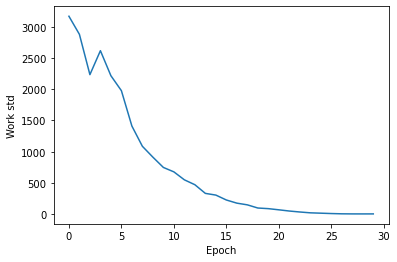

In [21]:
from matplotlib import pyplot as plt
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Work std')


Text(0.5, 1.0, 'Lambda Schedule for the first bond.')

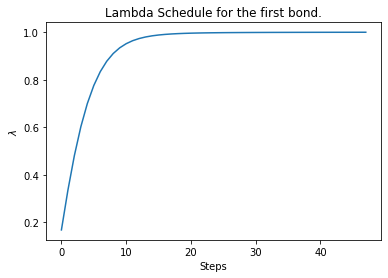

In [23]:
from matplotlib import pyplot as plt
plt.plot(g.nodes['n2'].data['lambs'][0].detach())
plt.xlabel('Steps')
plt.ylabel('$\lambda$')
plt.title('Lambda Schedule for the first bond.')

Text(0.5, 1.0, 'Lambda Schedule for the first angle.')

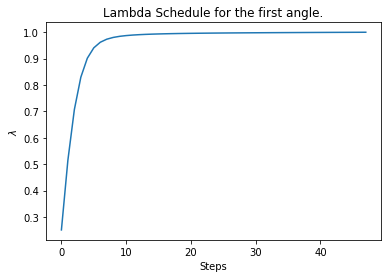

In [22]:
plt.plot(g.nodes['n3'].data['lambs'][0].detach())
plt.xlabel('Steps')
plt.ylabel('$\lambda$')
plt.title('Lambda Schedule for the first angle.')

In [18]:
import nglview as nv
from rdkit.Geometry import Point3D
from rdkit import Chem
from rdkit.Chem import AllChem

conf_idx = 0

mol = g.mol.to_rdkit()
AllChem.EmbedMolecule(mol)
conf = mol.GetConformer()
x = g.nodes['n1'].data['xyz'].detach().numpy()
for idx_atom in range(mol.GetNumAtoms()):
    conf.SetAtomPosition(
        idx_atom,
        Point3D(
            float(x[idx_atom, conf_idx, 0]),
            float(x[idx_atom, conf_idx, 1]),
            float(x[idx_atom, conf_idx, 2]),
        ))
    
nv.show_rdkit(mol)

NGLWidget()